# **Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import seaborn as sns

# **Data Visualization**

Not Target Based

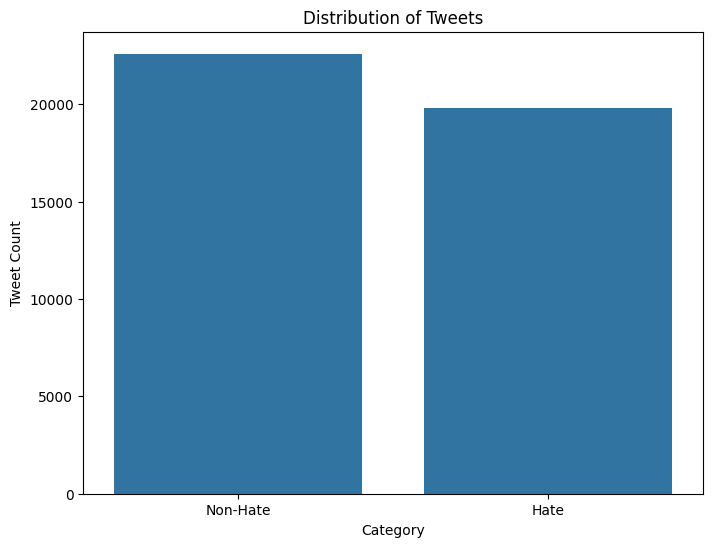

In [2]:
# Verileri yükle
train_data = pd.read_csv('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/train.csv')
val_data = pd.read_csv('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/val.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/test.csv')
# Nefret içeren ve içermeyen tweet'lerin sayısını görselleştir
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=train_data)
ax.set_title('Distribution of Tweets')
ax.set_xlabel('Category')
ax.set_ylabel('Tweet Count')
plt.xticks([0, 1], ['Non-Hate', 'Hate'])  # Etiket isimlerini belirtiniz
plt.show()

Target Based

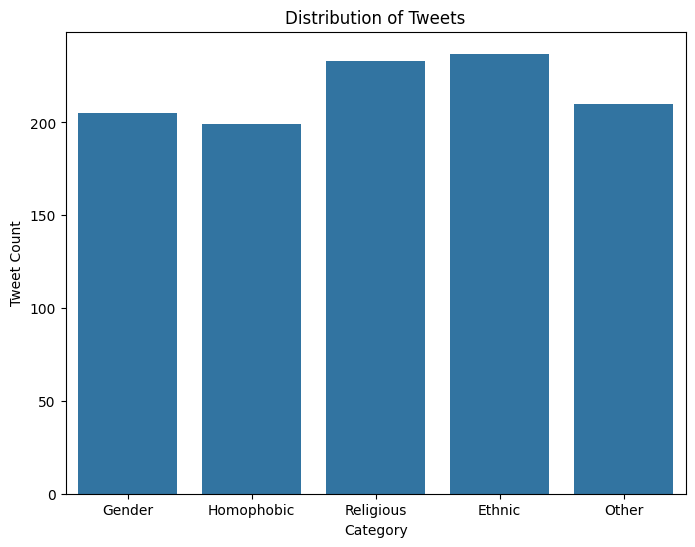

In [3]:
# Verileri yükle
targets = pd.read_csv('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target based/all_targets/target_all_other.csv')
# Nefret içeren ve içermeyen tweet'lerin sayısını görselleştir
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=targets)
ax.set_title('Distribution of Tweets')
ax.set_xlabel('Category')
ax.set_ylabel('Tweet Count')
plt.xticks([0, 1,2,3,4], ['Gender', 'Homophobic','Religious','Ethnic','Other'])  # Etiket isimlerini belirtiniz
plt.show()

# **Load model and tokenizer**

Not Target Based

In [4]:
# Model ve tokenizer'ı yükleyin
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/HateSpeech/model')
# tokenizer'ı yükleyin
model_name = "dbmdz/bert-base-turkish-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Cihaza taşıyın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Target Based

In [5]:
# Model ve tokenizer'ı yükleyin
model_target = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target_based_model/target_model_all')
tokenizer_target = BertTokenizer.from_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/target_based_model/target_tokenizer_all')

# Cihaza taşıyın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_target.to(device)
model_target.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# **Normalization before testing**

In [6]:
import re

def normalize_text(text):
    #Kullanıcı adlarını kaldırır
    #text = re.sub(r'([@][A-Za-z0-9_]+)|(\w+:\/\/\S+)','', text)

    text = re.sub(r'@\w+', '', text)
    # Tüm harfleri küçük harfe çevir (uncased model kullanılıyorsa)
    text = text.lower()

    # URL'leri kaldır
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # HTML etiketlerini kaldır
    text = re.sub(r'<.*?>', '', text)

    # Noktalama işaretleri dışındaki özel karakterleri kaldır
    text = re.sub(r'[^a-zA-Z0-9ığüşöçİĞÜŞÖÇ\s]', '', text)

    # Ekstra boşlukları kaldır
    text = re.sub(r'\s+', ' ', text).strip()


    #Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    emoji_pattern.sub(r' ', text)

    return text

Write the test texts here

In [7]:
# Girdi metin
texts =["🤢 LGBT bireyler toplumun pisliğidir! Onları toplumdan dışlamalıyız! 🌈🚫 #NoToLGBT",
        "🙄 Müslümanlar bu ülkeyi mahvediyor. Onların dini inançları yüzünden geri kalıyoruz. 🕌🚫 #Ateizm",
        "🤬 Kürtler bu ülkede gereksiz. Hepsi terörist! 🇹🇷🚫 #TeröristKürtler",
        "😡 Ermeniler bu topraklardan defolup gitmeli! Onlara burada yer yok. 🏞️🚫 #ErmenilereHayır",
        "🤮 Yaşlılar sokaklara çıkmasın. Evde oturup ölümü beklesinler! Amına koyduğumun yaşlıları! 👵🚫 #YaşlılaraHayır",
        "😤 TikTok dansı yapan herkes saçmalıyor. Bu aptallığa son verilmeli! Sikerim dansınızı! 📱🚫 #TikTokDansıYasaklansın",
        "Kadınların iş gücüne katılımı toplumsal gelişim için çok önemli. 💪👩‍💼 #Eşitlik",
        "Herkesin kimliğine saygı göstermeliyiz. Sevgi her zaman kazanır. 🌈❤️ #LGBTQ",
        "🤮 Evde oturup çocuk bakın, iş hayatı size göre değil! Amınıza koyayım, işleri zorlaştırıyorsunuz! 🏠❌ #KadınlarEvdeKalsın",
        "🤬 Kadınlar teknikte ne anlar? Sikerim teknik bilgilerini! 💻🚫 #KadınTeknisyenOlmasın",
        "😠 Yunanlar tarih boyunca hainlik yaptı. Sikerim sizin dostluğunuzu! 🇬🇷❌ #YunanDüşmanlığı",
        "🤬 Araplar bu ülkeye zarar veriyor. Hepsini anasını sikeyim, defolun! 🇸🇦🚫 #AraplarDefolsun",
        "🤬 Kafirler yüzünden ahlak çöktü. Amınıza koyayım, defolun! 🕌❌ #KafirlereHayır",
        "🤮 Hristiyan bayramlarını kutlayanlar gavurdur. Amınıza koyayım, burada kutlamayın! 🎄❌ #GavurBayramınaHayır",
        "🤬 Gayler yüzünden toplum bozuldu. Amınıza koyayım, defolun! 🏳️‍🌈❌ #GaylereGeçitYok",
        "😠 Eşcinsellerin hakları falan yok. İbne sürüsü defolup gitsin! 🚫🏳️‍🌈 #EşcinsellereHayır"]
non_target_labels = [1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1]
target_labels =     [1,2,3,3,4,4,4,4,0,0,3,3,2,2,1,1]


# Normalizasyonu uygulayın
normalized_texts = [normalize_text(text) for text in texts]
normalized_texts

['lgbt bireyler toplumun pisliğidir onları toplumdan dışlamalıyız notolgbt',
 'müslümanlar bu ülkeyi mahvediyor onların dini inançları yüzünden geri kalıyoruz ateizm',
 'kürtler bu ülkede gereksiz hepsi terörist teröristkürtler',
 'ermeniler bu topraklardan defolup gitmeli onlara burada yer yok ermenilerehayır',
 'yaşlılar sokaklara çıkmasın evde oturup ölümü beklesinler amına koyduğumun yaşlıları yaşlılarahayır',
 'tiktok dansı yapan herkes saçmalıyor bu aptallığa son verilmeli sikerim dansınızı tiktokdansıyasaklansın',
 'kadınların iş gücüne katılımı toplumsal gelişim için çok önemli eşitlik',
 'herkesin kimliğine saygı göstermeliyiz sevgi her zaman kazanır lgbtq',
 'evde oturup çocuk bakın iş hayatı size göre değil amınıza koyayım işleri zorlaştırıyorsunuz kadınlarevdekalsın',
 'kadınlar teknikte ne anlar sikerim teknik bilgilerini kadınteknisyenolmasın',
 'yunanlar tarih boyunca hainlik yaptı sikerim sizin dostluğunuzu yunandüşmanlığı',
 'araplar bu ülkeye zarar veriyor hepsini ana

# **Start with hate speech detection only**

In [8]:
# Tokenize edin
inputs = tokenizer(normalized_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Veriyi cihaza taşıyın
inputs = {key: val.to(device) for key, val in inputs.items()}

# Modeli kullanarak tahmin yapın
with torch.no_grad():
    outputs = model(**inputs)

# Çıktıları işleyin
logits = outputs.logits
predicted_class_ids = torch.argmax(logits, dim=1).tolist()

# Modelin sınıf etiketlerini tanımlayın
label_map = {0: "non-hate", 1: "hate"}  # Bu haritayı modelinize göre ayarlayın

predicted_labels = [label_map[id] for id in predicted_class_ids]

# Sonuçları yazdırın
for text, label in zip(normalized_texts, predicted_labels):
    print(f"Metin: '{text}'")
    print(f"Model Tahmini: {label} \n")

Metin: 'lgbt bireyler toplumun pisliğidir onları toplumdan dışlamalıyız notolgbt'
Model Tahmini: hate 

Metin: 'müslümanlar bu ülkeyi mahvediyor onların dini inançları yüzünden geri kalıyoruz ateizm'
Model Tahmini: hate 

Metin: 'kürtler bu ülkede gereksiz hepsi terörist teröristkürtler'
Model Tahmini: hate 

Metin: 'ermeniler bu topraklardan defolup gitmeli onlara burada yer yok ermenilerehayır'
Model Tahmini: hate 

Metin: 'yaşlılar sokaklara çıkmasın evde oturup ölümü beklesinler amına koyduğumun yaşlıları yaşlılarahayır'
Model Tahmini: hate 

Metin: 'tiktok dansı yapan herkes saçmalıyor bu aptallığa son verilmeli sikerim dansınızı tiktokdansıyasaklansın'
Model Tahmini: hate 

Metin: 'kadınların iş gücüne katılımı toplumsal gelişim için çok önemli eşitlik'
Model Tahmini: non-hate 

Metin: 'herkesin kimliğine saygı göstermeliyiz sevgi her zaman kazanır lgbtq'
Model Tahmini: non-hate 

Metin: 'evde oturup çocuk bakın iş hayatı size göre değil amınıza koyayım işleri zorlaştırıyorsunuz 

# **Then if hate find the target**

In [9]:
for text, predicted_label in zip(normalized_texts, predicted_labels):
    if predicted_label == "hate":
      # Tokenize edin
      inputs = tokenizer_target(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Veriyi cihaza taşıyın
      inputs = {key: val.to(device) for key, val in inputs.items()}

      # Modeli kullanarak tahmin yapın
      with torch.no_grad():
          outputs = model_target(**inputs)

      # Çıktıları işleyin
      logits = outputs.logits
      predicted_class_id = torch.argmax(logits, dim=1).item()

      # Modelin sınıf etiketlerini tanımlayın
      label_map = {0: "gender", 1: "homophobic", 2: "Religious", 3: "Ethnic",4: "Other"}  # Bu haritayı modelinize göre ayarlayın

      predicted_label = label_map[predicted_class_id]

      print(f"Metin: '{text}'")
      print(f"Model Tahmini: {predicted_label}\n")
    else:
      print("Not Hate\n")

Metin: 'lgbt bireyler toplumun pisliğidir onları toplumdan dışlamalıyız notolgbt'
Model Tahmini: homophobic

Metin: 'müslümanlar bu ülkeyi mahvediyor onların dini inançları yüzünden geri kalıyoruz ateizm'
Model Tahmini: Religious

Metin: 'kürtler bu ülkede gereksiz hepsi terörist teröristkürtler'
Model Tahmini: Ethnic

Metin: 'ermeniler bu topraklardan defolup gitmeli onlara burada yer yok ermenilerehayır'
Model Tahmini: Ethnic

Metin: 'yaşlılar sokaklara çıkmasın evde oturup ölümü beklesinler amına koyduğumun yaşlıları yaşlılarahayır'
Model Tahmini: Other

Metin: 'tiktok dansı yapan herkes saçmalıyor bu aptallığa son verilmeli sikerim dansınızı tiktokdansıyasaklansın'
Model Tahmini: Other

Not Hate

Not Hate

Metin: 'evde oturup çocuk bakın iş hayatı size göre değil amınıza koyayım işleri zorlaştırıyorsunuz kadınlarevdekalsın'
Model Tahmini: gender

Metin: 'kadınlar teknikte ne anlar sikerim teknik bilgilerini kadınteknisyenolmasın'
Model Tahmini: gender

Metin: 'yunanlar tarih boyunc